# Blight Violation Problem

## Exploring data

In [1]:
import pandas as pd
import numpy as np

In [119]:
#Reading training data/test data + addresses and latitude/longitude files allowing
#to replace blight violation adresses with map coordinates
train_df = pd.read_csv('readonly/train.csv',engine='python')
test_df = pd.read_csv('readonly/test.csv',engine='python')
addresses_df = pd.read_csv('readonly/addresses.csv',engine='python')
latlons_df = pd.read_csv('readonly/latlons.csv',engine='python')

The aim in the following is to identify and select useful data to optimize training

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [110]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61001 entries, 0 to 61000
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticket_id                   61001 non-null  int64  
 1   agency_name                 61001 non-null  object 
 2   inspector_name              61001 non-null  object 
 3   violator_name               60973 non-null  object 
 4   violation_street_number     61001 non-null  float64
 5   violation_street_name       61001 non-null  object 
 6   violation_zip_code          24024 non-null  object 
 7   mailing_address_str_number  59987 non-null  object 
 8   mailing_address_str_name    60998 non-null  object 
 9   city                        61000 non-null  object 
 10  state                       60670 non-null  object 
 11  zip_code                    60998 non-null  object 
 12  non_us_str_code             0 non-null      float64
 13  country                     610

Some features are available only in the training data and not in the test data (they will be dropped): payment_amount, payment_date, payment_status, balance_due, compliance_detail

compliance is the target. For this assignment only defined value will be considered (drop of Nan).

For the feature choice, memory limitations must be accounted for.

In [178]:
train_to_use = train_df.drop(columns=['collection_status','payment_amount','payment_date','payment_status','balance_due','compliance_detail'])
#We consider only tickets for which we know if the payment has been made or not
train_to_use = train_to_use[np.isfinite(train_to_use['compliance'])]

In [179]:
#Replace violation_street_number+violation_street_name with latitude and longitude (drop zip code)
train_to_use = pd.merge(train_to_use, pd.merge(addresses_df, latlons_df), on='ticket_id')
test_to_use = pd.merge(test_df, pd.merge(addresses_df, latlons_df, on='address'), on='ticket_id')
train_to_use = train_to_use.drop(columns=['address','violation_street_number','violation_street_name',
                                          'violation_zip_code'])
test_to_use = test_to_use.drop(columns=['address','violation_street_number','violation_street_name','violation_zip_code'])

In [180]:
#ticket_issue_date and hearing_date: change type to_datetime
train_to_use['ticket_issued_date'] = pd.to_datetime(train_to_use['ticket_issued_date'])
train_to_use['hearing_date'] = pd.to_datetime(train_to_use['hearing_date'])
#Create new feature: delta_date => number of days between ticket and hearing
train_to_use['delta_date'] = pd.to_numeric((train_to_use['hearing_date'].dt.date-train_to_use['ticket_issued_date'].dt.date).dt.days,downcast='integer')
train_to_use['delta_date'] = train_to_use['delta_date'].fillna(0)
#Drop very small fraction where delta_date < 0 (hearing_date before ticket_issue_date)
train_to_use = train_to_use[train_to_use['delta_date']>=0]
train_to_use['ticket_issued_month'] = train_to_use['ticket_issued_date'].dt.month
train_to_use['ticket_issued_day'] = train_to_use['ticket_issued_date'].dt.day
train_to_use['ticket_issued_time'] = train_to_use['ticket_issued_date'].dt.hour*3600+train_to_use['ticket_issued_date'].dt.minute*60+train_to_use['ticket_issued_date'].dt.second
train_to_use['hearing_month'] = train_to_use['hearing_date'].dt.month
train_to_use['hearing_day'] = train_to_use['hearing_date'].dt.day
train_to_use['hearing_time'] = train_to_use['hearing_date'].dt.hour*3600+train_to_use['hearing_date'].dt.minute*60+train_to_use['hearing_date'].dt.second
train_to_use['hearing_date'] = train_to_use['hearing_date'].fillna(0)
train_to_use['hearing_month'] = train_to_use['hearing_month'].fillna(0)
train_to_use['hearing_day'] = train_to_use['hearing_day'].fillna(0)
train_to_use['hearing_time'] = train_to_use['hearing_time'].fillna(0)

#Same for test set
test_to_use['ticket_issued_date'] = pd.to_datetime(test_to_use['ticket_issued_date'])
test_to_use['hearing_date'] = pd.to_datetime(test_to_use['hearing_date'])
#Create new feature: delta_date => number of days between ticket and hearing
test_to_use['delta_date'] = pd.to_numeric((test_to_use['hearing_date'].dt.date-test_to_use['ticket_issued_date'].dt.date).dt.days,downcast='integer')
test_to_use['delta_date'] = test_to_use['delta_date'].fillna(0)
#Drop very small fraction where delta_date < 0 (hearing_date before ticket_issue_date)
test_to_use = test_to_use[test_to_use['delta_date']>=0]
test_to_use['ticket_issued_month'] = test_to_use['ticket_issued_date'].dt.month
test_to_use['ticket_issued_day'] = test_to_use['ticket_issued_date'].dt.day
test_to_use['ticket_issued_time'] = test_to_use['ticket_issued_date'].dt.hour*3600+test_to_use['ticket_issued_date'].dt.minute*60+test_to_use['ticket_issued_date'].dt.second
test_to_use['hearing_month'] = test_to_use['hearing_date'].dt.month
test_to_use['hearing_day'] = test_to_use['hearing_date'].dt.day
test_to_use['hearing_time'] = test_to_use['hearing_date'].dt.hour*3600+test_to_use['hearing_date'].dt.minute*60+test_to_use['hearing_date'].dt.second
test_to_use['hearing_date'] = test_to_use['hearing_date'].fillna(0)
test_to_use['hearing_month'] = test_to_use['hearing_month'].fillna(0)
test_to_use['hearing_day'] = test_to_use['hearing_day'].fillna(0)
test_to_use['hearing_time'] = test_to_use['hearing_time'].fillna(0)

Target unbalanced: in more than 9 cases over 10, tickets result in non-compliance

In [ ]:
#Explore features to possibly identify important/less important features
for col in train_to_use.columns:
    print(col)
    print(train_to_use[col].unique())
    print(len(train_to_use[col].unique()))

In [7]:
#Compute violation fraction, non compliant fraction, and compliant fraction along some axis
def fraction_of_interest(parameter_name):
    violation_fraction = np.zeros(len(train_to_use[parameter_name].unique()),np.float)
    non_compliant_fraction = np.zeros(len(train_to_use[parameter_name].unique()),np.float)
    for index, param in enumerate(train_to_use[parameter_name].unique()):
        if type(param) == str:
            violation_fraction[index] = len(train_to_use[train_to_use[parameter_name]==param])/len(train_to_use)*100.
            non_compliant_fraction[index] = len(train_to_use[(train_to_use[parameter_name]==param) & (train_to_use['compliance']==0)])/len(train_to_use[train_to_use[parameter_name]==param])*100.
    compliant_fraction = 100.-non_compliant_fraction
    return violation_fraction, non_compliant_fraction, compliant_fraction

In [8]:
%matplotlib notebook
import matplotlib.pylab as plt

In [9]:
#Plot two histograms: total violation fraction distribution (left) and fraction of compliance/non compliance
#for each feature (right)
def figure_fraction(parameter_name):
    fig, axs = plt.subplots(1, 2, sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0.02})
    (ax1, ax2) = axs
    param_name = train_to_use[parameter_name].unique()
    y_pos = np.arange(len(param_name))
    violation_fraction = np.zeros(len(param_name),np.float)
    non_compliant_fraction = np.zeros(len(param_name),np.float)
    for index, param in enumerate(param_name):
        if type(param) == str:
            violation_fraction[index] = len(train_to_use[train_to_use[parameter_name]==param])/len(train_to_use)*100.
            non_compliant_fraction[index] = len(train_to_use[(train_to_use[parameter_name]==param) & (train_to_use['compliance']==0)])/len(train_to_use[train_to_use[parameter_name]==param])*100.
            param_name[index] = param.replace(' ','\n')
    compliant_fraction = 100.-non_compliant_fraction
    ax1.barh(y_pos, violation_fraction, align='center')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(param_name,size=5)
    ax1.set_xlabel('Total violation fraction (%)')
    h = 0.3
    hist1 = ax2.barh(y_pos-h/2, non_compliant_fraction, height=h, color='r')
    hist2 = ax2.barh(y_pos+h/2, compliant_fraction, height=h, color='b')
    fig.legend((hist1,hist2),('Non compliant','compliant'))
    ax2.set_xlabel('Fraction per '+parameter_name+' (%)')
    fig.suptitle(parameter_name)
    for ax in fig.get_axes():
        ax.label_outer()

In [ ]:
#Too large: violator_name, mailing_address_str_number, mailing_address_str_name, city, zip_code, 
#Insignificant: non_us_str_code, country

### Example: agency_name

In [19]:
violation_fraction, non_compliant_fraction, compliant_fraction = fraction_of_interest('agency_name')

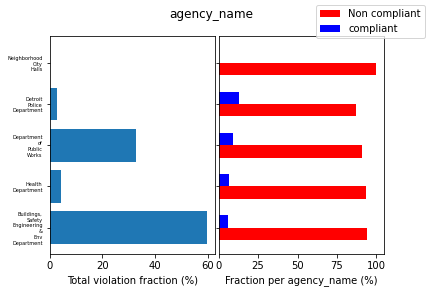

In [46]:
figure_fraction('agency_name')

### Another one: disposition

In [57]:
violation_fraction, non_compliant_fraction, compliant_fraction = fraction_of_interest('disposition')

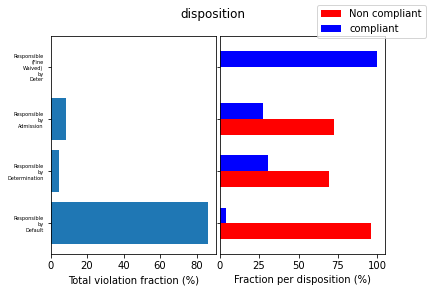

In [59]:
figure_fraction('disposition')

## ML algorithm 

### prepare train/test set 

In [181]:
train_to_use = train_to_use.drop(columns=['ticket_id','violator_name','ticket_issued_date','hearing_date',
                                          'violation_description','admin_fee','state_fee','late_fee',
                                          'clean_up_cost','mailing_address_str_number',
                                          'mailing_address_str_name','city','zip_code','non_us_str_code','country',
                                          'grafitti_status'])
test_to_use = test_to_use.drop(columns=['ticket_id','violator_name','ticket_issued_date','hearing_date',
                                        'violation_description','admin_fee','state_fee','late_fee',
                                        'clean_up_cost','mailing_address_str_number',
                                        'mailing_address_str_name','city','zip_code','non_us_str_code','country',
                                        'grafitti_status'])
train_to_use['state'] = train_to_use['state'].fillna(method='pad')
test_to_use['state'] = test_to_use['state'].fillna(method='pad')

In [182]:
#Before encoding disposition, rename properly since in some cases this feature provides direct hints about the outcome
train_to_use['disposition'] = train_to_use['disposition'].replace('Responsible (Fine Waived) by Deter','Responsible by Determination')
test_to_use['disposition'] = test_to_use['disposition'].replace('Responsible (Fine Waived) by Deter','Responsible by Determination')
test_to_use['disposition'] = test_to_use['disposition'].replace('Responsible (Fine Waived) by Admis','Responsible by Admission')
test_to_use['disposition'] = test_to_use['disposition'].replace('Responsible - Compl/Adj by Default','Responsible by Default')
test_to_use['disposition'] = test_to_use['disposition'].replace('Responsible - Compl/Adj by Determi','Responsible by Determination')

In [183]:
##Encode categorical data: encode only values found in both train/test set, ignore others (useless)
feature_list_to_encode = ['***'] #I do not want to provide a complete answer to this test
for param in feature_list_to_encode:
    CategoriesToKeep = np.intersect1d(test_to_use[param].unique(),train_to_use[param].unique()).tolist()
    train_to_use[param] = pd.Categorical(train_to_use[param],categories=CategoriesToKeep)
    train_to_use[param] = train_to_use[param].cat.add_categories('<'+param+'_unknown>').fillna('<'+param+'_unknown>')
    dummy_train = pd.get_dummies(train_to_use[param])
    train_to_use = train_to_use.join(dummy_train)
    train_to_use = train_to_use.drop(columns=param)
    test_to_use[param] = pd.Categorical(test_to_use[param],categories=CategoriesToKeep)
    test_to_use[param] = test_to_use[param].cat.add_categories('<'+param+'_unknown>').fillna('<'+param+'_unknown>')
    dummy_test = pd.get_dummies(test_to_use[param])
    dummy_test = dummy_test.reindex(columns = dummy_train.columns,fill_value=0)
    test_to_use = test_to_use.join(dummy_test)
    test_to_use = test_to_use.drop(columns=param)

In [192]:
train_to_use['lat'] = train_to_use['lat'].fillna(method='pad')
train_to_use['lon'] = train_to_use['lon'].fillna(method='pad')
test_to_use['lat'] = test_to_use['lat'].fillna(method='pad')
test_to_use['lon'] = test_to_use['lon'].fillna(method='pad')

### ML

In [187]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

In [ ]:
#Train different methods to pick the best one

cv = StratifiedKFold(n_splits=25)
scaler  = MinMaxScaler()
clfs = [LogisticRegression(),GaussianNB(),RandomForestClassifier(),
        AdaBoostClassifier()]
X = train_to_use.drop("compliance",1)
y = train_to_use.compliance

for clf in clfs:
    print(clf)
    for train, test in cv.split(X,y):
        X_train = scaler.fit_transform(X.iloc[train])
        X_test = scaler.transform(X.iloc[test])
        clf.fit(X_train,y.iloc[train])
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fpr, tpr, _ = roc_curve(y.iloc[test], prob_pos)
        auc_score = auc(fpr,tpr)
        print(auc_score)